In [290]:
using Pkg
Pkg.activate("../")

using StatsFuns
using Revise
using HiddenMarkovModel

 Activating environment at `~/GithubRepositories/HiddenMarkovModel/Project.toml`


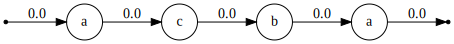

In [291]:
emissionsmap = Dict(
    "a" => 1,
    "b" => 2,
    "c" => 3,
    "d" => 4
)
sequence = ["a", "c", "b", "a"]
g1 = LinearGraph(sequence, emissionsmap)

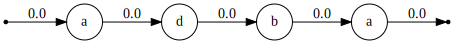

In [292]:
sequence = ["a", "d", "b", "a"]
g2 = LinearGraph(sequence, emissionsmap)

weightnormalize(g2)

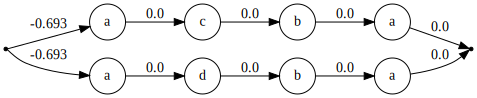

In [352]:
function union(g1::AbstractGraph, g2::AbstractGraph)
    g = Graph()
    statecount = 0
    old2new = Dict{AbstractState, AbstractState}(
        initstate(g1) => initstate(g),
        finalstate(g1) => finalstate(g),
    )
    for (i, state) in enumerate(states(g1))
        if id(state) ≠ finalstateid && id(state) ≠ initstateid
            statecount += 1
            old2new[state] = addstate!(g, State(statecount, pdfindex(state), name(state)))
        end
    end
    
    for state in states(g1)
        src = old2new[state]
        for link in children(state)
            link!(src, old2new[link.dest], link.weight)
        end
    end
    
    old2new = Dict{AbstractState, AbstractState}(
        initstate(g2) => initstate(g),
        finalstate(g2) => finalstate(g),
    )
    for (i, state) in enumerate(states(g2))
        if id(state) ≠ finalstateid && id(state) ≠ initstateid
            statecount += 1
            old2new[state] = addstate!(g, State(statecount, pdfindex(state), name(state)))
        end
    end
    
    for state in states(g2)
        src = old2new[state]
        for link in children(state)
            link!(src, old2new[link.dest], link.weight)
        end
    end
    
    g |> determinize |> weightnormalize
end
g = union(g1, g2)

In [353]:
function leftminimize!(g::Graph, state::AbstractState)
    leaves = Dict() 
    for link in children(state)
        leaf, weight = get(leaves, pdfindex(link.dest), ([], -Inf))
        push!(leaf, link.dest)
        leaves[pdfindex(link.dest)] = (leaf, logaddexp(weight, link.weight))
    end
    
    empty!(state.outgoing)
    for (nextstates, weight) in values(leaves)
        mergedstate = nextstates[1]
        filter!(l -> l.dest ≠ state, mergedstate.incoming)

        # Now we removed all the extra states of the graph.
        links = vcat([next.outgoing for next in nextstates[2:end]]...)
        for link in links
            link!(mergedstate, link.dest, link.weight)
        end
        
        for old in nextstates[2:end]
            for link in children(old)
                filter!(l -> l.dest ≠ old, link.dest.incoming)
            end
            delete!(g.states, id(old))
        end
        
        # Reconnect the previous state with the merged state
        link!(state, mergedstate, weight)
        
        # Minimize the subgraph.
        leftminimize!(g, mergedstate)
    end
    g 
end


function rightminimize!(g::Graph, state::AbstractState)
    leaves = Dict() 
    for link in parents(state)
        leaf, weight = get(leaves, pdfindex(link.dest), ([], -Inf))
        push!(leaf, link.dest)
        leaves[pdfindex(link.dest)] = (leaf, logaddexp(weight, link.weight))
    end
    
    empty!(state.incoming)
    for (nextstates, weight) in values(leaves)
        mergedstate = nextstates[1]
        filter!(l -> l.dest ≠ state, mergedstate.outgoing)

        # Now we removed all the extra states of the graph.
        links = vcat([next.incoming for next in nextstates[2:end]]...)
        for link in links
            #link!(mergedstate, link.dest, link.weight)
            link!(link.dest, mergedstate, link.weight)
        end
        
        for old in nextstates[2:end]
            for link in parents(old)
                filter!(l -> l.dest ≠ old, link.dest.outgoing)
            end
            delete!(g.states, id(old))
        end
        
        # Reconnect the previous state with the merged state
        link!(mergedstate, state, weight)
        
        # Minimize the subgraph.
        rightminimize!(g, mergedstate)
    end
    g 
end
minimize(g::Graph) = begin
    newg = deepcopy(g)
    newg = leftminimize!(newg, initstate(newg)) 
    rightminimize!(newg, finalstate(newg)) 
end

minimize (generic function with 1 method)

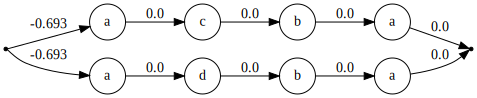

In [354]:
g

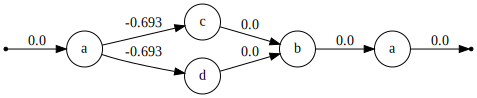

In [355]:
g = g |> minimize |> determinize |> weightnormalize

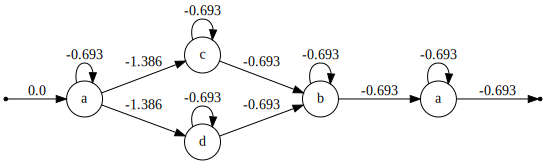

In [356]:
g = addselfloop(g) |> weightnormalize

In [403]:
for (sid, state) in g.states
    println("state $(state) : $(state.incoming)")
    println("---")
end

state State(id = initstateid, pdfindex = nothing, initstateid) : Link[]
---
state State(id = 7, pdfindex = 2, b) : Link[Link{Float64}(State(id = 7, pdfindex = 2, b), -0.6931471805599453), Link{Float64}(State(id = 2, pdfindex = 3, c), -0.6931471805599453), Link{Float64}(State(id = 6, pdfindex = 4, d), -0.6931471805599453)]
---
state State(id = 2, pdfindex = 3, c) : Link[Link{Float64}(State(id = 2, pdfindex = 3, c), -0.6931471805599453), Link{Float64}(State(id = 8, pdfindex = 1, a), -1.3862943611198906)]
---
state State(id = finalstateid, pdfindex = nothing, finalstateid) : Link[Link{Float64}(State(id = 5, pdfindex = 1, a), -0.6931471805599453)]
---
state State(id = 5, pdfindex = 1, a) : Link[Link{Float64}(State(id = 7, pdfindex = 2, b), -0.6931471805599453), Link{Float64}(State(id = 5, pdfindex = 1, a), -0.6931471805599453)]
---
state State(id = 8, pdfindex = 1, a) : Link[Link{Float64}(State(id = initstateid, pdfindex = nothing, initstateid), 0.0), Link{Float64}(State(id = 8, pdfindex =

In [391]:
llh = randn(4, 4)

4×4 Array{Float64,2}:
  0.393626  -0.831897   0.130839   -1.60193
  1.01238   -0.16196   -0.0855048   1.03511
 -0.580188  -0.621978   0.0923155   1.18269
  0.397424  -0.966615   0.464552    0.375744

In [395]:
αrecursion(g, llh) # the lower the more pruning 

4×4 Array{Float64,2}:
   0.393626   -1.13142  -1.69373  -3.39
 -Inf        -Inf       -1.89227   1.1712
 -Inf         -1.61465  -1.5794   -0.191604
 -Inf         -1.95928  -1.15086  -1.11546

In [396]:
lnαβ = αβrecursion(g, llh) # the lower the more pruning 
exp.(lnαβ)

4×4 Array{Float64,2}:
 1.0  0.540901  0.549474  1.0
 0.0  0.0       0.450526  0.0
 0.0  0.268718  0.0       0.0
 0.0  0.190381  0.0       0.0

State[State(id = 5, pdfindex = 1, a)]
[-4.083151668811988]
-----
State[State(id = 5, pdfindex = 1, a), State(id = 7, pdfindex = 2, b)]
[-4.681946269295651, -4.880490209299517]
-----
State[State(id = 5, pdfindex = 1, a), State(id = 7, pdfindex = 2, b)]
[-4.681946269295651, -Inf]
-----
State[State(id = 5, pdfindex = 1, a), State(id = 7, pdfindex = 2, b)]
[-4.68194626929565, -Inf]
-----


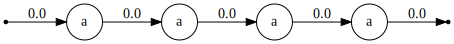

In [404]:
path = viterbi(g, llh)

In [375]:
g.states

Dict{Union{Missing, HiddenMarkovModel.FinalStateID, HiddenMarkovModel.InitStateID, Int64},State} with 7 entries:
  initstateid  => State(id = initstateid, pdfindex = nothing, initstateid)
  7            => State(id = 7, pdfindex = 2, b)
  2            => State(id = 2, pdfindex = 3, c)
  finalstateid => State(id = finalstateid, pdfindex = nothing, finalstateid)
  5            => State(id = 5, pdfindex = 1, a)
  8            => State(id = 8, pdfindex = 1, a)
  6            => State(id = 6, pdfindex = 4, d)

In [108]:
lnαβ = αβrecursion(g, llh, pruning = 2.1) # the lower the more pruning 
exp.(lnαβ)

4×3 Array{Float64,2}:
 1.0  0.0  0.0
 0.0  1.0  0.0
 0.0  0.0  0.466906
 0.0  0.0  0.533094

In [38]:
v = [(1, 3), (2, 2), (3, 1)]
findmax(v)

((3, 1), 3)